In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_selection import mutual_info_regression
from sklearn.impute import SimpleImputer
import lightgbm as lgbm
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope
import pickle
import re
import os

In [2]:
df = pd.read_csv(os.path.join(os.path.pardir, "data", "laptop_price.csv"), encoding_errors = "ignore")
df.head()

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
0,1,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69
1,2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
2,3,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,575.00
3,4,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2537.45
4,5,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.60


In [3]:
# drop first inches and id
df.drop(["Inches", "laptop_ID"], axis = 1, inplace = True)

In [4]:
X = df.drop("Price_euros", axis = 1).columns
y = "Price_euros"

In [5]:
df[X].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1303 entries, 0 to 1302
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Company           1303 non-null   object
 1   Product           1303 non-null   object
 2   TypeName          1303 non-null   object
 3   ScreenResolution  1303 non-null   object
 4   Cpu               1303 non-null   object
 5   Ram               1303 non-null   object
 6   Memory            1303 non-null   object
 7   Gpu               1303 non-null   object
 8   OpSys             1303 non-null   object
 9   Weight            1303 non-null   object
dtypes: object(10)
memory usage: 101.9+ KB


In [6]:
def handle_storage_space(x):
    spaces_lst = []
    for val in x.split():
        if "GB" in val or "TB" in val:
            if "TB" in val:
                spaces_lst.append(int(re.findall("\d+", val)[0])*1000)
            else:
                spaces_lst.append(int(re.findall("\d+", val)[0]))
    return sum(spaces_lst)

In [7]:
# data cleaning & preprocessing phase..
df["Ram"] = df["Ram"].apply(lambda x: x[:-2])
df["Ram"] = df["Ram"].astype("int8")
df["Weight"] = df["Weight"].apply(lambda x: x[:-2])
df["Weight"] = df["Weight"].astype("float16")
df["CPU_manufacturer"] = df["Cpu"].apply(lambda x: x.split()[0])
df["CPU_frequency"] = df["Cpu"].apply(lambda x: x.split()[-1])
df["CPU_frequency"] = df["CPU_frequency"].apply(lambda x: x[:-3])
df["CPU_frequency"] = df["CPU_frequency"].astype("float16")
df["CPU_model"] = df["Cpu"].apply(lambda x: x.split()[1:-1])
df["CPU_model"] = df["CPU_model"].apply(lambda x:''.join(val+'-' if idx != len(x)-1 else val for idx, val in enumerate(x)))
width_lst = df["ScreenResolution"].apply(lambda x:int(x.split()[-1].split(sep = "x")[0]) * 0.0264583333).values 
height_lst = df["ScreenResolution"].apply(lambda x:int(x.split()[-1].split(sep = "x")[1]) * 0.0264583333).values
df["screen_area_cm2"] = list(map(lambda x, y: x*y, width_lst, height_lst))
df["is_4K"] = df["ScreenResolution"].apply(lambda x: 1 if "4K Ultra HD" in x else 0)
df["is_touchscreen"] = df["ScreenResolution"].apply(lambda x: 1 if "Touchscreen" in x else 0)
df["is_full_HD"] = df["ScreenResolution"].apply(lambda x: 1 if "Full HD" in x else 0)
df["is_Quad"] = df["ScreenResolution"].apply(lambda x: 1 if "Quad" in x else 0)
df["is_HD+"] = df["ScreenResolution"].apply(lambda x: 1 if "HD+" in x else 0)
df["is_ips_panel"] = df["ScreenResolution"].apply(lambda x: 1 if "IPS Panel" in x else 0)
df["is_retina_display"] = df["ScreenResolution"].apply(lambda x: 1 if "Retina Display" in x else 0)
df["is_ssd"] = df["Memory"].apply(lambda x: 1 if "SSD" in x else 0)
df["is_hdd"] = df["Memory"].apply(lambda x: 1 if "HDD" in x else 0)
df["is_hybrid_storage"] = df["Memory"].apply(lambda x: 1 if "Hybrid" in x else 0)
df["is_flash_storage"] = df["Memory"].apply(lambda x: 1 if "Flash" in x else 0)
df["unique_storage_types"] = df["is_ssd"] + df["is_hdd"] + df["is_hybrid_storage"] + df["is_flash_storage"]
df["total_storage"] = df["Memory"].apply(handle_storage_space)
df["GPU_manufacturer"] = df["Gpu"].apply(lambda x:x.split()[0])
# Drop Raw Data Columns....
df.drop(["ScreenResolution", "Cpu", "Memory", "Gpu"], axis = 1, inplace = True)

In [8]:
df.drop("Product", axis = 1, inplace = True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1303 entries, 0 to 1302
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Company               1303 non-null   object 
 1   TypeName              1303 non-null   object 
 2   Ram                   1303 non-null   int8   
 3   OpSys                 1303 non-null   object 
 4   Weight                1303 non-null   float16
 5   Price_euros           1303 non-null   float64
 6   CPU_manufacturer      1303 non-null   object 
 7   CPU_frequency         1303 non-null   float16
 8   CPU_model             1303 non-null   object 
 9   screen_area_cm2       1303 non-null   float64
 10  is_4K                 1303 non-null   int64  
 11  is_touchscreen        1303 non-null   int64  
 12  is_full_HD            1303 non-null   int64  
 13  is_Quad               1303 non-null   int64  
 14  is_HD+                1303 non-null   int64  
 15  is_ips_panel         

In [10]:
company_enc = OrdinalEncoder()
type_enc = OrdinalEncoder()
os_enc = OrdinalEncoder()
cpu_manfacturer_enc = OrdinalEncoder()
cpu_model_enc = OrdinalEncoder()
gpu_manfacturer_enc = OrdinalEncoder()

In [11]:
# copy the dataframe.
pre_df = df.copy()

In [12]:
pre_df["Company"] = company_enc.fit_transform(pre_df["Company"].values.reshape(-1, 1))
pre_df["TypeName"] = company_enc.fit_transform(pre_df["TypeName"].values.reshape(-1, 1))
pre_df["OpSys"] = company_enc.fit_transform(pre_df["OpSys"].values.reshape(-1, 1))
pre_df["CPU_manufacturer"] = company_enc.fit_transform(pre_df["CPU_manufacturer"].values.reshape(-1, 1))
pre_df["CPU_model"] = company_enc.fit_transform(pre_df["CPU_model"].values.reshape(-1, 1))
pre_df["GPU_manufacturer"] = company_enc.fit_transform(pre_df["GPU_manufacturer"].values.reshape(-1, 1))

In [13]:
# categorical columns: Company:0, TypeName:1, OpSys:3, CPU_manufacturer:6, CPU_model:8, 
# is_4K':10, 'is_touchscreen':11, 'is_full_HD':12, 'is_Quad':13, 'is_HD+':14,
#'is_ips_panel':15, 'is_retina_display':16, 'is_ssd':17, 'is_hdd':18,
#'is_hybrid_storage':19, 'is_flash_storage':20, 'unique_storage_types:21, GPU_manufacturer:23
cat_idx = [0, 1, 3, 5, 7, 22]

In [14]:
cat_cols_idx = [0, 1, 3, 5, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22]

In [15]:
X = pre_df.drop("Price_euros", axis = 1)
y = pre_df["Price_euros"]
mi_scores = mutual_info_regression(X, y, discrete_features=cat_cols_idx)

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22],
 [Text(0, 0, 'Company'),
  Text(1, 0, 'TypeName'),
  Text(2, 0, 'Ram'),
  Text(3, 0, 'OpSys'),
  Text(4, 0, 'Weight'),
  Text(5, 0, 'CPU_manufacturer'),
  Text(6, 0, 'CPU_frequency'),
  Text(7, 0, 'CPU_model'),
  Text(8, 0, 'screen_area_cm2'),
  Text(9, 0, 'is_4K'),
  Text(10, 0, 'is_touchscreen'),
  Text(11, 0, 'is_full_HD'),
  Text(12, 0, 'is_Quad'),
  Text(13, 0, 'is_HD+'),
  Text(14, 0, 'is_ips_panel'),
  Text(15, 0, 'is_retina_display'),
  Text(16, 0, 'is_ssd'),
  Text(17, 0, 'is_hdd'),
  Text(18, 0, 'is_hybrid_storage'),
  Text(19, 0, 'is_flash_storage'),
  Text(20, 0, 'unique_storage_types'),
  Text(21, 0, 'total_storage'),
  Text(22, 0, 'GPU_manufacturer')])

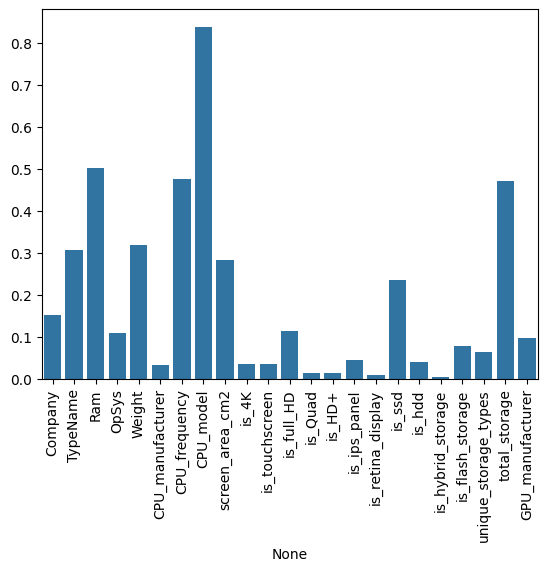

In [16]:
# Mutual Information Score for each feature...
sns.barplot(x = X.columns, y = mi_scores)
plt.xticks(rotation = 90)

In [17]:
# search space of lightgbm regressor
SEARCH_SPACE={
    "n_estimators":scope.int(hp.quniform("n_estimators", 20, 700, 5)),
    "max_depth":scope.int(hp.quniform("max_depth", 1, 12, 1)),
    "min_samples_split":scope.int(hp.quniform("num_leaves", 100, 150, 5)),
    "min_samples_leaf":scope.int(hp.quniform("min_samples_leaf", 30, 500, 20)),
    "learning_rate":scope.float(hp.quniform("learning_rate", 0.01, 0.3, 0.001)),
    "alpha":hp.loguniform("alpha", -5, -1),
    "random_state":42
}

In [18]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.15, random_state = 42)

In [19]:
def optimize(params):
    booster = GradientBoostingRegressor(**params)
    booster.fit(X_train, y_train)
    y_pred = booster.predict(X_valid)
    rmse = mean_squared_error(y_valid, y_pred, squared=False)
    return {"loss":rmse, "status":STATUS_OK}

In [20]:
best_res = fmin(
    fn = optimize,
    space = SEARCH_SPACE,
    algo = tpe.suggest,
    max_evals=25,
    trials=Trials()
)

100%|██████████| 25/25 [00:48<00:00,  1.94s/trial, best loss: 306.1901287420852] 


In [21]:
best_res

{'alpha': 0.048066298233883795,
 'learning_rate': 0.23500000000000001,
 'max_depth': 12.0,
 'min_samples_leaf': 80.0,
 'n_estimators': 475.0,
 'num_leaves': 135.0}

In [22]:
params = {'alpha': 0.12940376373416662,
 'learning_rate': 0.216,
 'max_depth': 12,
 'min_samples_leaf': 80,
 'n_estimators': 595,
 'min_samples_split': 100,
 'random_state':42}

In [23]:
cat_preprocessor = Pipeline(steps = [
    ("ordinal-enc", OrdinalEncoder())
])
preprocessor = ColumnTransformer(transformers = [
    ("cat", cat_preprocessor, cat_idx),
    ("other", "passthrough", [2, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21])
], remainder="passthrough")
model_pipeline = Pipeline(steps = [
    ("preprocessor", preprocessor),
    ("missing_handler", SimpleImputer(strategy='constant', fill_value=-1)),
    ("gb", GradientBoostingRegressor(**params))
])

In [24]:
X = df.drop("Price_euros", axis = 1)
y = df["Price_euros"]

In [25]:
model_pipeline.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('ordinal-enc',
                                                                   OrdinalEncoder())]),
                                                  [0, 1, 3, 5, 7, 22]),
                                                 ('other', 'passthrough',
                                                  [2, 4, 6, 8, 9, 10, 11, 12,
                                                   13, 14, 15, 16, 17, 18, 19,
                                                   20, 21])])),
                ('missing_handler',
                 SimpleImputer(fill_value=-1, strategy='constant')),
                ('gb',
                 GradientBoostingRegressor(alpha=0.12940376373416662,
                                           learning_rate=0.216, max_depth=12,
                                           min_samples_leaf=80,
                                           min_samples_split=100,
                                           n_estimators=595,
                                           random_state=42))])

In [26]:
mean_squared_error(y, model_pipeline.predict(X), squared = False)

161.00908295634264

In [27]:
with open(os.path.join(os.path.pardir, "app", "bin", "model-pipeline.pkl"), "wb") as pkl:
    pickle.dump(model_pipeline, pkl)